[Descripción y lineamientos del proyecto](https://docs.google.com/document/d/152L5VsLgPlLHH-Gz_93hOaG3J5BapcxNvHiXiYxhPdc/edit#heading=h.7092f8q9v51p)

[Notebook de la primera entrega](https://colab.research.google.com/drive/1LGyeJ74Oy1ixMHJuTEv-tgegAuyHmx1h?usp=sharing)

# 1. Revisión general de los datos

Luego de realizar el análisis exploratorio de datos, se observó que algunas queries realizadas a la API de noticias obtuvieron datos no relevantes para el proyecto, ya que, aunque eran fuentes de noticias colombianas, hacían referencia a artículos ajenos al país, por lo que inicialmente se deberá realizar una limpieza adicional de los datos. De igual manera, se observó que los artículos provenientes del diario "El Heraldo" contenían errores al incluir una sección con enlaces a otras noticias dentro de sus artículos, volviendo confusa la lectura de los mismos.

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
from tqdm import tqdm

drive.mount('/content/drive')

# Al realizar lo corrección de artículos del Heraldo, se obtiene una
# advertencia de Pandas, por lo que se desactivarán ciertas notificaciones
pd.set_option('mode.chained_assignment', None)

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/NewsAnalyzer/mixed_data_col.csv')

In [ ]:
# Inicialmente observamos una cantidad total de 5484 artículos
# entre los que se encuentran errores y noticias externas a Colombia

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5484 entries, 0 to 5483
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            5484 non-null   object
 1   dataType        5484 non-null   object
 2   url             5484 non-null   object
 3   title           5484 non-null   object
 4   body            5484 non-null   object
 5   relevance       5484 non-null   int64 
 6   author          5484 non-null   object
 7   titleSentiment  5484 non-null   int64 
 8   titleWords      5484 non-null   int64 
 9   bodyWords       5484 non-null   int64 
dtypes: int64(4), object(6)
memory usage: 428.6+ KB


## Corrección de errores en artículos y autor

Podemos notar que en el diario "El Heraldo" no hay consistencia en la escritura de su fuente, lo cual debe ser corregido.

En esta sección se mostrarán ejemplos de los errores mencionados anteriormente.

In [ ]:
# Ejemplo de artículos no relacionados con Colombia

df['body'][356]

"(Lea también: 'Fraude montado': Javier Milei redobla sus críticas e insiste que el intento de golpe de Estado en Bolivia fue falso)Este nuevo estado de excepción por 60 días abarca seis provincias (Guayas, Los Ríos, Manabí, Orellana, Santa Elena y El Oro) y el municipio de Camilo Ponce Enríquez, un enclave minero en la sureña provincia andina de Azuay donde en abril fue asesinado el alcalde y esta semana fueron hallados ocho cuerpos con signos de tortura en una concesión minera."

In [ ]:
# Ejemplo de diferencia en nombre del autor

df['author'][90]

'EL HERALDO'

In [ ]:
# Corrección del autor para diario El Heraldo

df['author'] = df['author'].apply(lambda x: 'elheraldo.co' if x == 'EL HERALDO' else x)

In [ ]:
def clean_errors(text: str) -> str:
  '''
  Función auxiliar para eliminar las noticias adicionales
  encontradas en artículos de El Heraldo.

  Args:
  text (str): texto a limpiar

  Returns:
  text (str): texto limpio
  '''

  idx = text.find('  ')
  if idx != -1:
    return text[idx + 2:]
  return text

In [ ]:
for i in range(len(df)):
  if df['author'][i] == 'elheraldo.co':
    df['body'][i] = clean_errors(df['body'][i])

In [ ]:
# Palabras clave a ser retiradas de los artículos

keywords = [
    'ucrania', 'hamas', 'hezbola', 'hamás', 'hezbolá', 'bolivia',
    'israel', 'crimea', 'rusia', 'rusos', 'kremlin', 'haiti',
    'mexico', 'pensilvania', 'wikileaks', 'assange', 'trump',
    'palestina', 'gaza', 'palestinos'
]

mask = df['title'].apply(lambda x: not any(keyword in x.lower() for keyword in keywords))

df_filtered = df[mask]

In [ ]:
# Al eliminar las noticias que trataban dichos temas notamos una reducción
# de 509 entradas de datos irrelevantes

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4975 entries, 0 to 5483
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            4975 non-null   object
 1   dataType        4975 non-null   object
 2   url             4975 non-null   object
 3   title           4975 non-null   object
 4   body            4975 non-null   object
 5   relevance       4975 non-null   int64 
 6   author          4975 non-null   object
 7   titleSentiment  4975 non-null   int64 
 8   titleWords      4975 non-null   int64 
 9   bodyWords       4975 non-null   int64 
dtypes: int64(4), object(6)
memory usage: 427.5+ KB


# 2. Machine Learning

Para alcanzar el objetivo fijado en la primera entrega del proyecto, un paso fundamental es comprobar la veracidad y credibilidad de las noticias, lo que al final dará a conocer medios con artículos de mayor relevancia para el público general, así como aquellos que tienden a escribir mayormente basándose en opiniones.

Otro paso fundamental, será conocer aquellos temas más relevantes en las noticias halladas.

## Selección y descarga del modelo a utilizar

Para esta sección se utilizará el modelo Llama 3.1 de Meta, el cual fue publicado el 23 de Julio del 2024 y es hasta el momento, uno de los modelos con mejores puntajes en diversos benchmark de LLMs.

[Blog de lanzamiento de Llama 3.1](https://ai.meta.com/blog/meta-llama-3-1/)

Para esta entrega se utilizará la versión [llama3.1:8b-instruct-q4_1](https://ollama.com/library/llama3.1:8b-instruct-q4_1) encontrada en Ollama, ya que permite emplear la GPU de Colab sin ralentizar tanto el procesamiento. Su implementación tomó aproximadamente dos horas sobre la base de casi 5000 artículos. Sin embargo, para futuras versiones, de ser necesario, se empleará un modelo más cuantizado o con mayor número de parámetros para incrementar la capacidad y precisión del mismo.

In [ ]:
# Instalamos Ollama y una terminal para ejecutarla en Colab

!pip install langchain_community -q
!curl -fsSL https://ollama.com/install.sh | sh
!pip install colab-xterm

%load_ext colabxterm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.6/990.6 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.9/379.9 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 13.2 MB/s eta 0:00:00
>>> Downloading ollama...
############################################################################################# 100.0%
>>> Installing ollama to /usr/local/bin...
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
   ━━━

In [ ]:
# Ejecutamos el comando 'ollama serve' en la terminal

%xterm

Launching Xterm...

<IPython.core.display.Javascript object>

In [ ]:
# Traemos el modelo seleccionado desde Ollama

!ollama pull llama3.1:8b-instruct-q4_1

pulling manifest ⠙ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠸ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest 
pulling 8d58d46be388...   0% ▕▏    0 B/5.1 GB                  pulling manifest 
pulling 8d58d46be388...   0% ▕▏    0 B/5.1 GB                  pulling manifest 
pulling 8d58d46be388...   0% ▕▏    0 B/5.1 GB                  pulling manifest 
pulling 8d58d46be388...   0% ▕▏    0 B/5.1 GB                  pulling manifest 
pulling 8d58d46be388...   0% ▕▏    0 B/5.1 GB                  pulling manifest 
pulling 8d58d46be388...   0% ▕▏    0 B/5.1 GB                  p

In [ ]:
# Importamos las librerías necesarias para trabajar con Ollama y langchain

from operator import itemgetter
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

## Verificación de hechos vs opiniones

Se utilizará una función auxiliar con el prompt correspondiente para etiquetar las noticias entre 0 y 5, donde 0 es opinión y 5 es basado en hechos. Esta escala fue utilizada debido a que el modelo no cuenta con una precisión perfecta, y de esta manera se reduce un poco su sesgo de entrenamiento.

Por medio de experimentación se determinó a su vez que hubo artículos que no pudieron ser clasificados, por lo que se adicionó una condición en la que, al no poder completarla, su valor será -1, lo cual podrá deberse a distintos factores, tales como noticias incompletas, errores de redacción o del texto en sí. También si se tratan hechos completamente ficticios podrían clasificarse como -1, como se demostrará en un ejemplo más adelante.

Para posteriores experimentaciones y modelos, podrá modificarse el valor de la temperatura del LLM, para permitirle mayor libertad al momento de tomar decisiones, en este caso se notó un mejor resultado limitándolo a 0.

In [ ]:
def fact_check(news_article: str)-> int:
  '''
  Verificador de hechos de noticias empleando Llama 3.1

  Args:
  news_article (str): Texto a verificarse

  Returns:
  estimated_class (int): Puntaje obtenido por el modelo
  '''

  prompt = ChatPromptTemplate.from_messages([
    (
        "system", "You are a fact checking classifier for news articles in Spanish.\n"
        "You should output an integer score from 0 to 5:\n"
        "Where 0 means opinion based and 5 is fact based.\n"
        "If you fail to classify an article, give it a -1 as score\n"
        "You must be critic about it, without saying your critics.\n"
        "Answer only with the corresponding score"
    ),
    (
        "human", "check the following article and determine if it's based on \
        verifiable facts or is an opinion:\n\"{text}\""
    )
  ])

  model = "llama3.1:8b-instruct-q4_1"

  llm = ChatOllama(temperature=0, model=model)

  output_parser = StrOutputParser()

  chain = (
      prompt
      | llm
      | output_parser
  )

  estimated_class = chain.invoke({"text":news_article})

  return estimated_class

In [ ]:
# Ejemplo de uso, 'Taikuatku' es un país inventado

news_article = """
La legislación de Taikuatku indicó una falla general en el sistema
de telecomunicaciones mundial
"""

result = fact_check(news_article)
print("Resultado:", result)

Resultado: -1


Ejecución de prueba para observar posibles resultados y las noticias que los produjeron.

In [ ]:
from tqdm import tqdm

X = df_filtered['body'].iloc[:5].to_list()
fact_check_col = []

for text in tqdm(X):
  fact_check_col.append(int(fact_check(text)))

100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


In [ ]:
fact_check_col

[4, 4, 0, 2, -1]

In [ ]:
X

['La propuesta de reforma a los servicios públicos en Colombia, liderada por el Gobierno de Gustavo Petro, ha desatado un intenso debate en el ámbito político, empresarial y social del país. Esta iniciativa buscaría reestructurar la regulación vigente para fortalecer el control estatal sobre las empresas prestadoras de servicios públicos, con el objetivo declarado de mejorar la calidad del servicio y proteger los derechos de los usuarios.  Esta medida, aunque argumentada como necesaria para unificar criterios y fortalecer la supervisión, ha sido duramente criticada por su potencial impacto en la competencia del mercado. Organizaciones como Andesco advierten que podría poner en riesgo la diversidad empresarial actualmente existente, clave para mantener precios competitivos y fomentar la innovación en la prestación de servicios esenciales como el agua y la energía.  El sector de servicios públicos en Colombia se encuentra en vísperas de una transformación significativa con la próxima dis

Podemos observar que las primeras dos noticias obtuvieron un puntaje bastante alto, y al verificar su contenido, se determinó la veracidad de los artículos. En los siguientes se pudo apreciar que el tercero obtuvo un puntaje de 0, y esto es consistente con la noticia, ya que habla directamente sobre una opinión dada de una persona acerca de otra.

La cuarta noticia habla desde la perspectiva de un periodista, el cual está hablando de hechos reales, pero con una posición y tonalidad bastante personal, lo que disminuye su puntaje.

En el último valor, notamos que la noticia se encuentra incompleta, y su contenido no permite validar por completo la veracidad del mismo, por lo que el modelo lo clasifica con un valor de -1 correctamente.

In [ ]:
X = df_filtered['body'].to_list()
fact_check_col = []

for text in tqdm(X):
  fact_check_col.append(fact_check(text))

100%|██████████| 4975/4975 [1:54:12<00:00,  1.38s/it]


In [ ]:
df_filtered['factScore'] = fact_check_col

In [ ]:
df_filtered.to_csv(
    '/content/drive/MyDrive/NewsAnalyzer/verified_data.csv',
    index=False,
    encoding='utf-8-sig'
)

## Análisis de tema central

En esta sección se utilizará nuevamente el modelo anterior, pero con un enfoque diferente, ya que esta vez se le pedirá escoger el tema central del artículo en cuestión, para luego realizar el análisis correspondiente.

Al igual que en el apartado anterior, se empleará una función auxiliar, la cual contendrá el prompt y el resultado de la llamada al modelo. En caso de no fallar en la clasificación, deberá indicar "None", para poder identificar fácilmente cuáles presentaron errores.

In [ ]:
def topic_verification(news_article: str)-> str:
  '''
  Obtiene la temática principal de noticias empleando Llama 3.1

  Args:
  news_article (str): Texto a analizar

  Returns:
  main_topic (str): Tema central de la noticia
  '''

  prompt = ChatPromptTemplate.from_messages([
    (
        "system", "You are a news articles analyzer in Spanish.\n"
        "You should output one word containing the main topic of the article:\n"
        "If you fail to classify an article, write 'None'\n"
        "Keep the words list to a maximum of 20 to avoid using too many topics.\n"
        "Answer only with the corresponding word"
    ),
    (
        "human", "check the following article and determine its main topic:\n\"{text}\""
    )
  ])

  model = "llama3.1:8b-instruct-q4_1"

  llm = ChatOllama(temperature=0.25, model=model)

  output_parser = StrOutputParser()

  chain = (
      prompt
      | llm
      | output_parser
  )

  main_topic = chain.invoke({"text":news_article})

  return main_topic

In [ ]:
# Ejemplo de uso, 'Taikuatku' es un país inventado

news_article = """
La legislación de Taikuatku indicó una falla general en el sistema
de telecomunicaciones mundial
"""

result = topic_verification(news_article)
print("Resultado:", result)

Resultado: Telecomunicaciones


Ejecución de prueba para observar posibles resultados y las noticias que los produjeron.

In [ ]:
X = df_filtered['body'].iloc[:5].to_list()
topic_col = []

for text in tqdm(X):
  topic_col.append(topic_verification(text))

100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


In [ ]:
topic_col

['Reforma', 'Pensiones', 'Gobierno', 'Educación', 'Educación']

In [ ]:
X = df_filtered['body'].to_list()
topic_col = []

for text in tqdm(X):
  topic_col.append(topic_verification(text))

100%|██████████| 4975/4975 [57:52<00:00,  1.43it/s]


In [ ]:
df_filtered['mainTopic'] = topic_col

## Exportación del set de datos final

De esta manera se tendrá un punto de control al cual volver en caso de necesitar realizar análisis posteriores.

A su vez, se verificará que todas las entradas de datos contengan el formato correcto, de lo contrario, realizar las correcciones, para el factScore cambiar por -1 cualquier valor con longitud mayor a 1, ya que los resultados deben estar entre 0 y 5, y en el mainTopic modificar a "None" todos aquellos que cuenten con más de una palabra (ya que esto representa que se hizo un bypass al artículo sin clasificar).

In [ ]:
df_filtered['factScore'].unique()

array(['0', '4', '2', '-1',
       'La ley estatutaria de educación es un proyecto de ley que busca convertir la educación en un derecho fundamental del ciudadano y garantizar su acceso a una formación superior o técnica, financiada por el Estado. Sin embargo, el texto aprobado en la Comisión Primera del Senado ha generado preocupación entre las organizaciones sindicales y educativas debido a que destina parte de los recursos del Estado en educación a instituciones particulares cuyo fin fundamental es generar ganancias, lo que podría disminuir los recursos para las entidades públicas.',
       '5',
       'El Comité de Seguimiento y Monitoreo considera que la situación del Acuerdo de Paz en Colombia es compleja y requiere un enfoque integral. Aunque reconoce que el gobierno ha avanzado en algunos aspectos, como la creación del Ministerio de la Igualdad, también destaca los rezagos en la implementación y la necesidad de subsanar problemas legales para garantizar su funcionamiento efecti

In [ ]:
df_filtered['mainTopic'].unique()

array(['Reforma', 'Pensiones', 'Gobierno', 'Educación', 'Unidad',
       'Polémica',
       'En la pregunta, el sindicato Sindesena critica el proyecto de ley estatutaria de educación por incluir a instituciones particulares en la financiación de la educación y disminuir los recursos para las entidades públicas. También se oponen a que el texto cree un nivel de educación terciaria sin sustento normativo y elimine las líneas divisorias entre la educación formal, no formal e informal.',
       'Política', 'Piratería', 'Policía', 'Cuba', 'Corralito',
       'Colombia', 'Petro', 'Asesinatos', 'Atentado', 'Paz', 'Corrupción',
       'Salud', 'Cáncer', "AFP's", 'Seguridad', 'Paro', 'Congreso',
       'Pobreza', 'Tauromaquia',
       'El Comité de Seguimiento y Monitoreo considera que la situación del Acuerdo de Paz en Colombia es compleja, pero no tan drástica como para requerir medidas extremas como convocar una Asamblea Constituyente. En su lugar, sugieren que el gobierno y el Congreso tra

In [ ]:
final_df = df_filtered.copy()

final_df['factScore'] = final_df['factScore'].apply(lambda x: -1 if len(x) > 1 else int(x))
final_df['mainTopic'] = final_df['mainTopic'].apply(lambda x: 'None' if len(x.split()) > 1 else x)

In [ ]:
final_df.to_csv(
    '/content/drive/MyDrive/NewsAnalyzer/data_after_ml.csv',
    index=False,
    encoding='utf-8-sig'
)

In [ ]:
final_df.head(5)

,date,dataType,url,title,body,relevance,author,titleSentiment,titleWords,bodyWords,factScore,mainTopic
0,2024-07-08,news,https://diariodelhuila.com/reforma-integral-de...,Reforma Integral de Servicios Públicos en Colo...,La propuesta de reforma a los servicios públic...,16,Diario del Huila,5,14,1116,0,Reforma
1,2024-06-24,news,https://www.semana.com/politica/articulo/urgen...,Urgente: esta es la prueba reina de que Asofon...,"Tuve la peor noche de mi vida, creí que no iba...",11,Semana.com Últimas Noticias de Colombia y el...,1,26,459,4,Pensiones
2,2024-06-29,news,https://www.semana.com/politica/articulo/los-e...,"Los escándalos de Luis Fernando Velasco, a qui...",Me dolió: Néstor Lorenzo destapó verdad de Jam...,16,Semana.com Últimas Noticias de Colombia y el...,1,19,519,0,Gobierno
3,2024-07-09,news,https://www.semana.com/confidenciales/articulo...,"Su legado, dejar a la Nacional en una de las p...","'No se trata de quién se ponga más bravo, sino...",7,Semana.com Últimas Noticias de Colombia y el...,5,21,295,2,Educación
4,2024-06-21,news,https://www.semana.com/politica/articulo/petro...,Petro atacó a David Luna y el senador lo paró ...,También indicó: El debate actual en el senado ...,16,Semana.com Últimas Noticias de Colombia y el...,1,26,107,-1,Educación


# Resultados obtenidos

En este apartado se mostrarán algunos resultados de la clasificación obtenidos por el modelo, con la finalidad de tomar decisiones para una siguiente iteración.

* Distribución del "fact score", para consolidar el número de errores y los valores más utilizados por el modelo.
* Visualización de los autores agrupados por su puntuación promedio:
  * 10 mejores
  * 10 intermedios
  * 10 peores
* Cuentas clasificadas con un puntaje promedio de -1.

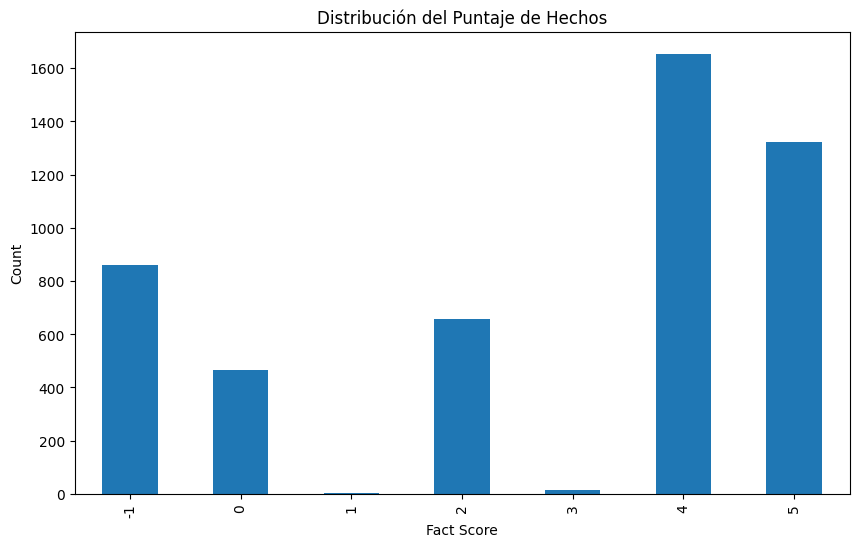

In [ ]:
import matplotlib.pyplot as plt

# Gráfico de distribución de puntajes
plt.figure(figsize=(10, 6))
final_df['factScore'].value_counts().sort_index().plot(kind='bar')

plt.xlabel('Fact Score')
plt.ylabel('Count')
plt.title('Distribución del Puntaje de Hechos')

plt.show()

<ipython-input-44-ce6518c6d34b>:32: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from current font.
  plt.tight_layout()
<ipython-input-44-ce6518c6d34b>:32: UserWarning: Glyph 27665 (\N{CJK UNIFIED IDEOGRAPH-6C11}) missing from current font.
  plt.tight_layout()
<ipython-input-44-ce6518c6d34b>:32: UserWarning: Glyph 32593 (\N{CJK UNIFIED IDEOGRAPH-7F51}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27665 (\N{CJK UNIFIED IDEOGRAPH-6C11}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32593 (\N{CJK UNIFIED IDEOGRAPH-7F51}) missing from current font.
  fig.canvas.print_

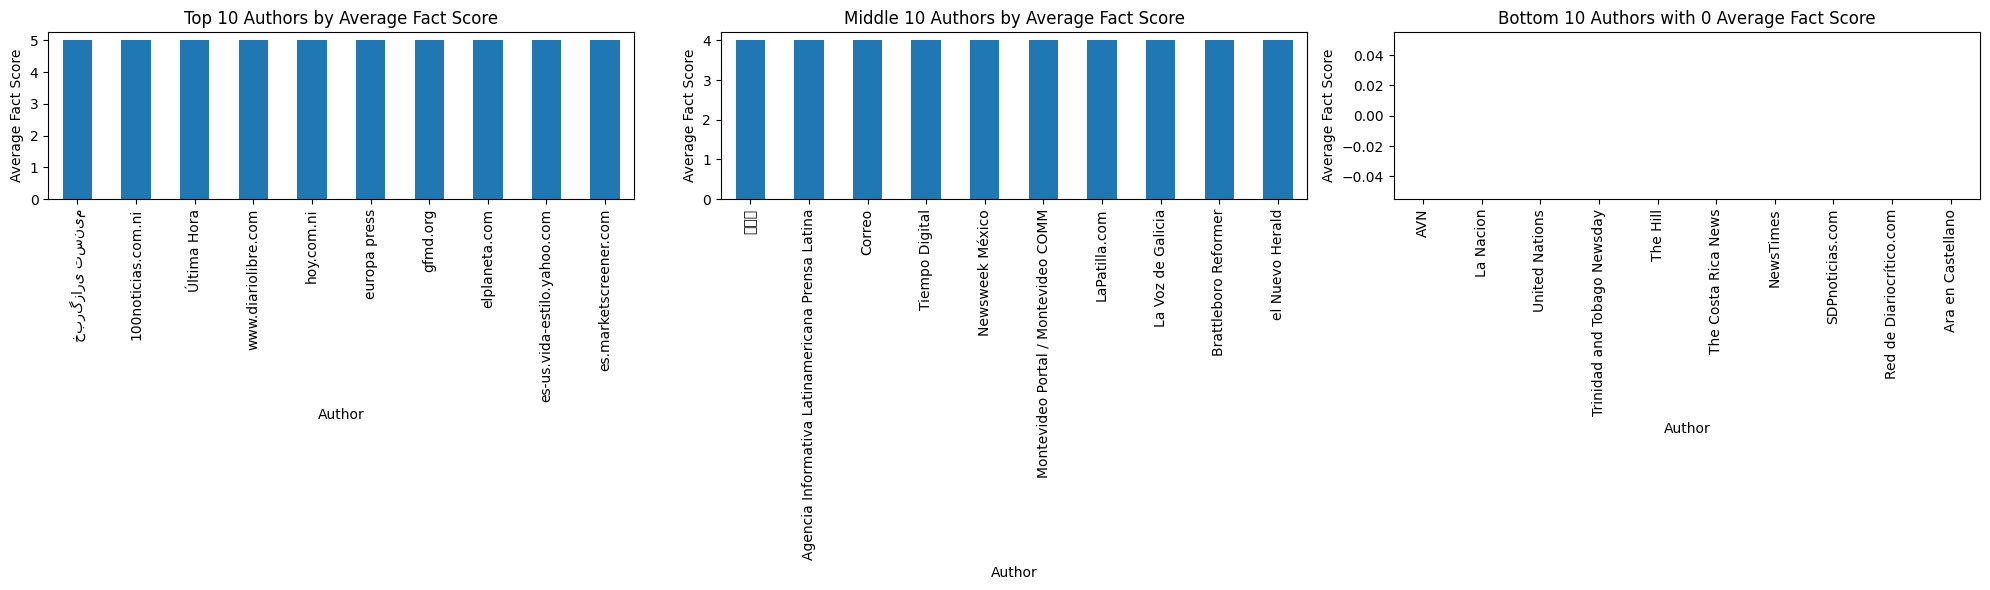

In [ ]:
# Fact score promedio por autor
author_scores = final_df.groupby('author')['factScore'].mean()

sorted_authors = author_scores.sort_values(ascending=False)

# Top 10, 10 intermedios y 10 peores
top_10 = sorted_authors.head(10)
middle_10 = sorted_authors[len(sorted_authors)//2 - 5 : len(sorted_authors)//2 + 5]
bottom_10 = sorted_authors[sorted_authors == 0].tail(10)

# Gráfico
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

top_10.plot(kind='bar', ax=axes[0])
axes[0].set_title('Top 10 Authors by Average Fact Score')
axes[0].set_xlabel('Author')
axes[0].set_ylabel('Average Fact Score')

middle_10.plot(kind='bar', ax=axes[1])
axes[1].set_title('Middle 10 Authors by Average Fact Score')
axes[1].set_xlabel('Author')
axes[1].set_ylabel('Average Fact Score')

bottom_10.plot(kind='bar', ax=axes[2])
axes[2].set_title('Bottom 10 Authors with 0 Average Fact Score')
axes[2].set_xlabel('Author')
axes[2].set_ylabel('Average Fact Score')

plt.tight_layout()
plt.show()

In [ ]:
# Fact score por autor
author_scores = final_df.groupby('author')['factScore'].mean()

# Filtro de autores con puntajes promedio de -1
authors_with_minus_one = author_scores[author_scores == -1]

authors_with_minus_one

author
Activist Post                                                             -1.0
Americas Quarterly                                                        -1.0
Blogs El Espectador                                                       -1.0
Center for Economic and Policy Research                                   -1.0
Cerosetenta                                                               -1.0
Cleveland American                                                        -1.0
Colorado Springs Gazette                                                  -1.0
Common Dreams                                                             -1.0
Consortiumnews                                                            -1.0
Counter Punch                                                             -1.0
EXTRA.CW                                                                  -1.0
Eagle-Tribune                                                             -1.0
El Confidencial                              

# Conclusiones

* En los gráficos y la tabla anteriores se observó un número significativo de errores de clasificación del modelo, por lo que para una siguiente iteración se repetirá el procedimiento con la versión fp16 de 8b del modelo Llama 3.1, o en su defecto, una versión de 70b.
* Como posible solución al objetivo general del proyecto, se planteará la posibilidad de adicionar también el análisis del modelo acerca de cada noticia al momento de realizar la clasificación, a modo de entregar al usuario final mayor información sobre la decisión tomada.
* La ejecución de LLMs en Colab para realizar clasificaciones similares a la anterior, requieren de un alto consumo de máquinas virtuales, por lo que será imperativo emplear alguna de las suscripciones de pago para obtener un mayor rendimiento y mejorar los resultados.